<h1> Spotify Skip Prediction Dataset </h1>
This dataset comes in two sets. The first set is details about 'sessions': chunks of songs a user listens to in one go, and what songs were listened to. The second set details the song's features. <br>
Our analysis will include just the mini set availible on AI Crowd which we have also provided on GitHub. The input we are using is an augmented table that combines the user session data and the song features data. 
There are 167880 entires and 50 total features. Only 47 features will be used. 

<h3>References</h3>
We'd like to recognize that due to enormity of this dataset and the complexity of how it was stored (in multiple seperate and unorganized .csv files), we did use online references to decide on our stack and how we would approach the data. <br>
We used the following a examples: <br> <br>
<li> <a>https://github.com/a-poor/spotify-skip-prediction/blob/master/README.md</a>
<br><i>Used for template tech stack and reorganize dataset. </i>

<h2>Import Libraries and Datasets</h2>

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load both CSV files into DataFrames
log_df = pd.read_csv('log_mini.csv') # User log
tf_df  = pd.read_csv('tf_mini.csv')  # Track features
 
# Rename the column track_id_clean to track_id so User log and Track features can be merged on track_id
log_df = log_df.rename(columns={'track_id_clean': 'track_id'})

# Perform a merge so that song information is attached to the user information
og_data_df = pd.merge(log_df, tf_df, on='track_id')

# Save the merged DataFrame to a new CSV file
og_data_df.to_csv('merged_file.csv', index=False)
data_df = og_data_df

In [25]:
# Optional prints to check the structure and shape of the DataFrame
print(data_df.head(3).to_markdown())
print(data_df.shape)


|    | session_id                             |   session_position |   session_length | track_id                               | skip_1   | skip_2   | skip_3   | not_skipped   |   context_switch |   no_pause_before_play |   short_pause_before_play |   long_pause_before_play |   hist_user_behavior_n_seekfwd |   hist_user_behavior_n_seekback | hist_user_behavior_is_shuffle   |   hour_of_day | date       | premium   | context_type       | hist_user_behavior_reason_start   | hist_user_behavior_reason_end   |   duration |   release_year |   us_popularity_estimate |   acousticness |   beat_strength |   bounciness |   danceability |   dyn_range_mean |   energy |   flatness |   instrumentalness |   key |   liveness |   loudness |   mechanism | mode   |   organism |   speechiness |   tempo |   time_signature |   valence |   acoustic_vector_0 |   acoustic_vector_1 |   acoustic_vector_2 |   acoustic_vector_3 |   acoustic_vector_4 |   acoustic_vector_5 |   acoustic_vector_6 |   acoustic_vector_7 |

# Reorganizing the Data
We decided to select the the variable skip_3 as our 'y' variable. The 'skip_3' feautre represents when a 

In [26]:
# Making a 'skipped' feature for whether a song has been skipped or not, regardless of how fast
data_df['skipped'] = (data_df.skip_3 | data_df.skip_2 | data_df.skip_1).astype('int32')

# Make 'skipped' column our 'y' value for prediction
y_df = data_df['skipped']

# Drop stratified skip columns since they have been aggregated into one column
data_df = data_df.drop(columns=["skip_1", "skip_2", "skip_3", "not_skipped"], axis=1)

# Optional print just to check features
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 47 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   track_id                         167880 non-null  object 
 4   context_switch                   167880 non-null  int64  
 5   no_pause_before_play             167880 non-null  int64  
 6   short_pause_before_play          167880 non-null  int64  
 7   long_pause_before_play           167880 non-null  int64  
 8   hist_user_behavior_n_seekfwd     167880 non-null  int64  
 9   hist_user_behavior_n_seekback    167880 non-null  int64  
 10  hist_user_behavior_is_shuffle    167880 non-null  bool   
 11  hour_of_day                      167880 non-null  int64  
 12  da

## Dealing with Non-Float Values
The IDs of the songs and the users are strings. We've chosen to completely drop these values. While it is reasonable to assume they impact the predicted value, we opt to focus on more generally modeling whether a song will be skipped or not as opposed to whether a song will be skipped or not depending on previous skips and sessions since there are 10,000 sessions in the mini dataset, a value we are not sure how to deal with considering the reasources we have.

###

In [27]:
# Drop ID values
data_df = data_df.drop(columns=["session_id", "track_id"], axis=1)

In [28]:
# Decompose the session_date column into year, month, and day numerical features. 
data_df['session_year'] = pd.to_datetime(data_df['date']).dt.year
data_df['session_month'] = pd.to_datetime(data_df['date']).dt.month
data_df['session_day_of_week'] = pd.to_datetime(data_df['date']).dt.dayofweek

# Removing the date feature now that it has been decomposed
data_df = data_df.drop('date', axis=1)

# Optional Print To Check Structure
print(data_df.head(3).to_markdown())



|    |   session_position |   session_length |   context_switch |   no_pause_before_play |   short_pause_before_play |   long_pause_before_play |   hist_user_behavior_n_seekfwd |   hist_user_behavior_n_seekback | hist_user_behavior_is_shuffle   |   hour_of_day | premium   | context_type       | hist_user_behavior_reason_start   | hist_user_behavior_reason_end   |   duration |   release_year |   us_popularity_estimate |   acousticness |   beat_strength |   bounciness |   danceability |   dyn_range_mean |   energy |   flatness |   instrumentalness |   key |   liveness |   loudness |   mechanism | mode   |   organism |   speechiness |   tempo |   time_signature |   valence |   acoustic_vector_0 |   acoustic_vector_1 |   acoustic_vector_2 |   acoustic_vector_3 |   acoustic_vector_4 |   acoustic_vector_5 |   acoustic_vector_6 |   acoustic_vector_7 |   skipped |   session_year |   session_month |   session_day_of_week |
|---:|-------------------:|-----------------:|-----------------:|-------

In [29]:
# Encode boolean values of premium feature as int (True:1, False:0)
data_df['premium'] = data_df['premium'].astype(int)

# Encode boolean values of hist_user_behavior_is_shuffle feature as int (True:1, False:0)
data_df['hist_user_behavior_is_shuffle'] = data_df['hist_user_behavior_is_shuffle'].astype(int)

# Encode non-numerical values of mode feature as int (major:1, minor:0)
data_df['mode'] = data_df['mode'].map({'major':1, 'minor':0})

# Optional Print To Check Encoding
print(data_df.head(3).to_markdown())


|    |   session_position |   session_length |   context_switch |   no_pause_before_play |   short_pause_before_play |   long_pause_before_play |   hist_user_behavior_n_seekfwd |   hist_user_behavior_n_seekback |   hist_user_behavior_is_shuffle |   hour_of_day |   premium | context_type       | hist_user_behavior_reason_start   | hist_user_behavior_reason_end   |   duration |   release_year |   us_popularity_estimate |   acousticness |   beat_strength |   bounciness |   danceability |   dyn_range_mean |   energy |   flatness |   instrumentalness |   key |   liveness |   loudness |   mechanism |   mode |   organism |   speechiness |   tempo |   time_signature |   valence |   acoustic_vector_0 |   acoustic_vector_1 |   acoustic_vector_2 |   acoustic_vector_3 |   acoustic_vector_4 |   acoustic_vector_5 |   acoustic_vector_6 |   acoustic_vector_7 |   skipped |   session_year |   session_month |   session_day_of_week |
|---:|-------------------:|-----------------:|-----------------:|-------

### Categorical Variables
The following variables were categorical in nature:
* time_signature
* key_signature
* context_type
* hist_user_behavior_reason_start	
* hist_user_behavior_reason_end
<br><br>Lets analyze how many types of values are in each column to determine whether one-hot encoding or ordinal encoding is more advantageous. 

In [30]:
list = ['time_signature', 'key', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end' ]

for col in list:
    unique_values = data_df[col].unique()
    print(col, ": ", unique_values)

time_signature :  [4 5 3 1 0]
key :  [ 1  7 10  8  6  5  4  2  0  3  9 11]
context_type :  ['editorial_playlist' 'user_collection' 'catalog' 'radio' 'charts'
 'personalized_playlist']
hist_user_behavior_reason_start :  ['trackdone' 'fwdbtn' 'appload' 'playbtn' 'clickrow' 'backbtn' 'remote'
 'endplay' 'trackerror']
hist_user_behavior_reason_end :  ['trackdone' 'endplay' 'fwdbtn' 'backbtn' 'remote' 'logout' 'clickrow']


### Analyzing Unique Values
For *time signature*, due to the ordered nature, we will use *ordinal* encoding.
For *context_type*, *key*, *hist_user_behavior_reason_start*, and *hist_user_behavior_reason_end* we will use *one-hot* encoding as their seems to be no inheret order to the values. 

Let's make the changes now!

## One-Hot Encoding


In [32]:
from sklearn.preprocessing import OneHotEncoder

# Encoding our categorical features and making a DataFrame of these encoded features
encoder = OneHotEncoder()
categorical_features = ['key', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
encoded_data = encoder.fit_transform(data_df[categorical_features])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_features))

# Combining the encoded DataFrame with our original DataFrame, dropping the un-encoded categorical features
data_df = pd.concat([data_df.reset_index(drop=True), encoded_df], axis=1)
data_df.drop(categorical_features, axis=1, inplace=True)

# Optional Print To Check Encoding
print(data_df.head(3).to_markdown())


|    |   session_position |   session_length |   context_switch |   no_pause_before_play |   short_pause_before_play |   long_pause_before_play |   hist_user_behavior_n_seekfwd |   hist_user_behavior_n_seekback |   hist_user_behavior_is_shuffle |   hour_of_day |   premium |   duration |   release_year |   us_popularity_estimate |   acousticness |   beat_strength |   bounciness |   danceability |   dyn_range_mean |   energy |   flatness |   instrumentalness |   liveness |   loudness |   mechanism |   mode |   organism |   speechiness |   tempo |   time_signature |   valence |   acoustic_vector_0 |   acoustic_vector_1 |   acoustic_vector_2 |   acoustic_vector_3 |   acoustic_vector_4 |   acoustic_vector_5 |   acoustic_vector_6 |   acoustic_vector_7 |   skipped |   session_year |   session_month |   session_day_of_week |   key_0 |   key_1 |   key_2 |   key_3 |   key_4 |   key_5 |   key_6 |   key_7 |   key_8 |   key_9 |   key_10 |   key_11 |   context_type_catalog |   context_type_charts | 

### Check for Missing Values

In [37]:
# Check for missing values within columns
missing_values = data_df.isnull().sum()
columns_missing_values = missing_values[missing_values > 0]

# Display columns with missing values and counts
if not columns_missing_values.empty:
    print("Columns with missing values:")
    print(columns_missing_values)

### Split Data into Test and Training Sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data_df, y_df, test_size=0.2, random_state=42)

# Optional Print To Check Info In DataFrame
print(data_df.head(3).to_markdown())

|    |   session_position |   session_length |   context_switch |   no_pause_before_play |   short_pause_before_play |   long_pause_before_play |   hist_user_behavior_n_seekfwd |   hist_user_behavior_n_seekback |   hist_user_behavior_is_shuffle |   hour_of_day |   premium |   duration |   release_year |   us_popularity_estimate |   acousticness |   beat_strength |   bounciness |   danceability |   dyn_range_mean |   energy |   flatness |   instrumentalness |   liveness |   loudness |   mechanism |   mode |   organism |   speechiness |   tempo |   time_signature |   valence |   acoustic_vector_0 |   acoustic_vector_1 |   acoustic_vector_2 |   acoustic_vector_3 |   acoustic_vector_4 |   acoustic_vector_5 |   acoustic_vector_6 |   acoustic_vector_7 |   skipped |   session_year |   session_month |   session_day_of_week |   key_0 |   key_1 |   key_2 |   key_3 |   key_4 |   key_5 |   key_6 |   key_7 |   key_8 |   key_9 |   key_10 |   key_11 |   context_type_catalog |   context_type_charts | 

# Model #1: Logistic Regression
Our first model will be a logistic regression model using sklearn's implementation. 


In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

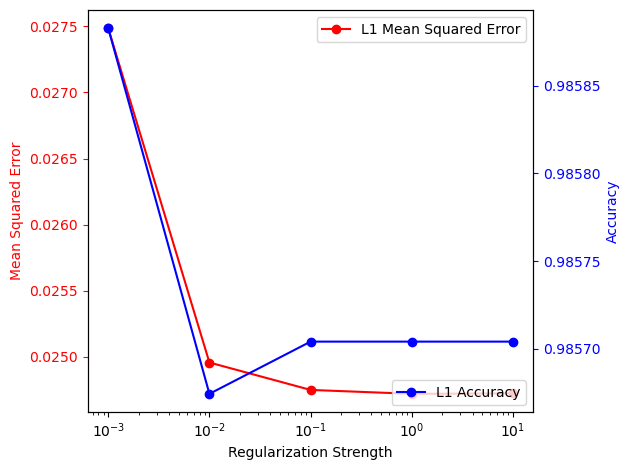

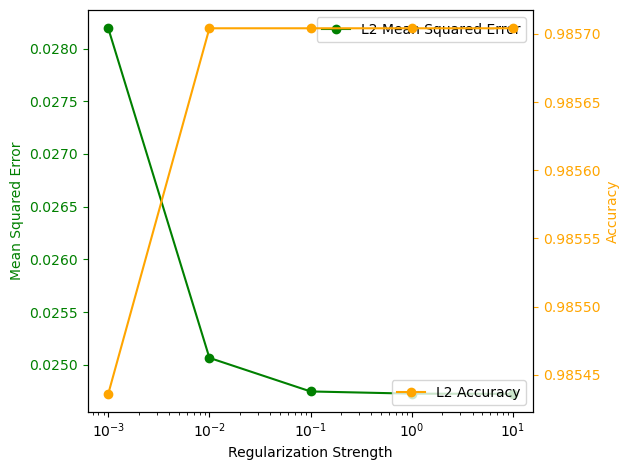

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END logisticregression__C=1, logisticregression__penalty=l2, selectkbest__k=10; total time=   4.9s
[CV] END logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=10; total time=   5.8s
[CV] END logisticregression__C=10, logisticregression__penalty=l2, selectkbest__k=10; total time=   5.9s
[CV] END logisticregression__C=1, logisticregression__penalty=l2, selectkbest__k=10; total time=   5.6s
[CV] END logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=10; total time=   6.0s
[CV] END logisticregression__C=0.1, logisticregression__penalty=l2, selectkbest__k=10; total time=   6.1s
[CV] END logisticregression__C=1, logisticregression__penalty=l2, selectkbest__k=10; total time=   6.2s
[CV] END logisticregression__C=10, logisticregression__penalty=l2, selectkbest__k=10; total time=   6.2s
[CV] END logisticregression__C=10, logisticregression__penalty=l2, selectkbest__k=10; total time=   1

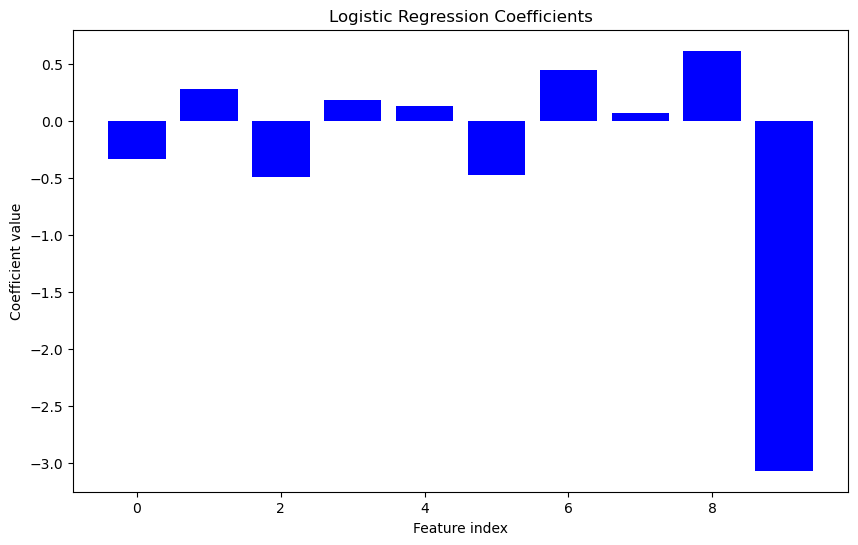

Training Accuracy (Transformed): 0.9863369668811055
Validation Accuracy (Transformed): 0.9863071869706328
ROC-AUC Score (Transformed): 0.9804483545374146


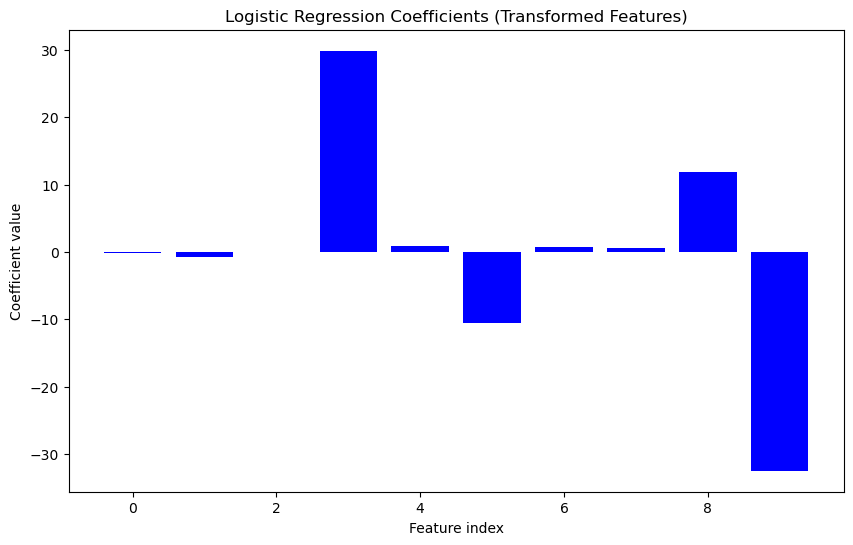

'\n#_______________________________________________________________________________________________________________________________\n#The following is the code used in implementing polynomial feature transformations on the dataset.\n#\n#Due to our data reorginzation and preprocessing, we have 76 features in our feature space. For polynomial transformation,\n#that would require being able to computationally sustain the square of the number of our original features, so 5625 features.\n#Working with 5625 features is far too computationally taxing, which has led us to put our efforts toward another type of \n#feature transformation.\n#_______________________________________________________________________________________________________________________________\n\n\npipeline_poly = make_pipeline(\n    VarianceThreshold(),  \n    StandardScaler(),\n    PolynomialFeatures(degree=2, include_bias=False),\n    SelectKBest(k=10),\n    LogisticRegression(solver=\'saga\', tol=0.1, max_iter=500)\n)\

In [45]:


# 1. Testing Different Regularization Strengths for L1 and L2 Penalties
def test_regularization_strengths(X_train, y_train, X_test, y_test, reg_types=['l1', 'l2'], strengths=[0.001, 0.01, 0.1, 1, 10]):
    results = {}

    for reg_type in reg_types:
        errors = []
        accuracies = []

        for C in strengths:
            model = LogisticRegression(C=C, penalty=reg_type, solver='saga', max_iter=5000, tol=0.001)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            errors.append(mean_squared_error(y_test, y_prob))
            accuracies.append(accuracy_score(y_test, y_pred))

        results[reg_type] = {'errors': errors, 'accuracies': accuracies}

    return results

def plot_results(results, strengths):
    for reg_type, metrics in results.items():
        fig, ax1 = plt.subplots()
        ax1.semilogx(strengths, metrics['errors'], 'o-', color="r" if reg_type == 'l1' else "g", label=f'{reg_type.upper()} Mean Squared Error')
        ax1.set_xlabel('Regularization Strength')
        ax1.set_ylabel('Mean Squared Error', color='r' if reg_type == 'l1' else "g")
        ax1.tick_params('y', colors='r' if reg_type == 'l1' else "g")
        ax1.legend(loc='upper right')

        ax2 = ax1.twinx()
        ax2.semilogx(strengths, metrics['accuracies'], 'o-', color="b" if reg_type == 'l1' else "orange", label=f'{reg_type.upper()} Accuracy')
        ax2.set_ylabel('Accuracy', color='b' if reg_type == 'l1' else "orange")
        ax2.tick_params('y', colors='b' if reg_type == 'l1' else "orange")
        ax2.legend(loc='lower right')

        fig.tight_layout()
        plt.show()

# Run and plot regularization test
results = test_regularization_strengths(X_train, y_train, X_test, y_test)
plot_results(results, [0.001, 0.01, 0.1, 1, 10])

# 2. Cross-Validation with GridSearch
def perform_grid_search(X_train, y_train):
    pipeline = make_pipeline(
        VarianceThreshold(threshold=0.0),
        StandardScaler(),
        SelectKBest(f_classif),
        LogisticRegression(solver='saga', tol=0.01, max_iter=5000)
    )

    param_grid = {
        'selectkbest__k': [10],  # If you want to explore more, try [5, 10, 20]
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__penalty': ['l2']
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)
    return grid_search

# Perform grid search
grid_search_1 = perform_grid_search(X_train, y_train)
train_accuracy_1 = accuracy_score(y_train, grid_search_1.predict(X_train))
validation_accuracy_1 = grid_search_1.best_score_

print("Training Accuracy: ", train_accuracy_1)
print("Validation Accuracy: ", validation_accuracy_1)
print("Best Parameters: ", grid_search_1.best_params_)

# 3. Evaluate the Best Model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    probabilities = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, probabilities)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    print("ROC-AUC Score:", roc_auc)

    return model.named_steps['logisticregression'].coef_

# Evaluate the best model
coefficients = evaluate_model(grid_search_1.best_estimator_, X_test, y_test)

# 4. Plot Coefficients
def plot_coefficients(coefficients, title='Logistic Regression Coefficients'):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(coefficients)), coefficients, color='blue', capsize=5)
    plt.xlabel('Feature index')
    plt.ylabel('Coefficient value')
    plt.title(title)
    plt.show()

# Plot the coefficients
plot_coefficients(coefficients.ravel())

# 5. Transformed Feature Analysis (as needed)
def transformed_feature_analysis(X_train, y_train, X_test, y_test, best_params_):
    constant = abs(min(np.min(X_train), np.min(X_test))) + 1e-5
    X_train_transformed = np.sqrt(X_train + constant)
    X_test_transformed = np.sqrt(X_test + constant)

    selector = SelectKBest(f_classif, k=10)
    X_train_selected = selector.fit_transform(X_train_transformed, y_train)
    X_test_selected = selector.transform(X_test_transformed)

    logreg_transformed = LogisticRegression(C=best_params_['logisticregression__C'], solver='saga', max_iter=5000, tol=0.001)
    logreg_transformed.fit(X_train_selected, y_train)

    y_pred_transformed = logreg_transformed.predict(X_test_selected)
    training_accuracy_transformed = accuracy_score(y_train, logreg_transformed.predict(X_train_selected))
    validation_accuracy_transformed = np.mean(cross_val_score(logreg_transformed, X_train_selected, y_train, cv=5))

    roc_auc_transformed = roc_auc_score(y_test, y_pred_transformed)
    coefficients_transformed = logreg_transformed.coef_.ravel()

    print("Training Accuracy (Transformed):", training_accuracy_transformed)
    print("Validation Accuracy (Transformed):", validation_accuracy_transformed)
    print("ROC-AUC Score (Transformed):", roc_auc_transformed)

    return coefficients_transformed

# Analyze and plot transformed features
coefficients_transformed = transformed_feature_analysis(X_train, y_train, X_test, y_test, grid_search_1.best_params_)
plot_coefficients(coefficients_transformed, title='Logistic Regression Coefficients (Transformed Features)')



In [ ]:
"""
#_______________________________________________________________________________________________________________________________
#The following is the code used in implementing polynomial feature transformations on the dataset.
#
#Due to our data reorginzation and preprocessing, we have 76 features in our feature space. For polynomial transformation,
#that would require being able to computationally sustain the square of the number of our original features, so 5625 features.
#Working with 5625 features is far too computationally taxing, which has led us to put our efforts toward another type of 
#feature transformation.
#_______________________________________________________________________________________________________________________________


pipeline_poly = make_pipeline(
    VarianceThreshold(),  
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    SelectKBest(k=10),
    LogisticRegression(solver='saga', tol=0.1, max_iter=500)
)

param_grid_poly = {
    'polynomialfeatures__degree': [1, 2], 
    'selectkbest__k': [10],  
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2']
}

grid_search_2 = GridSearchCV(pipeline_poly, param_grid_poly, cv=cv, n_jobs=-1, verbose=2)

grid_search_2.fit(X_train, y_train)
train_accuracy_2 = accuracy_score(y_train, grid_search_2.predict(X_train))
validation_accuracy_2 = grid_search_2.best_score_
print("Degree 2 - Training Accuracy: ", train_accuracy_2)
print("Degree 2 - Validation Accuracy: ", validation_accuracy_2)
"""

# Model #2: SVM

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# C = 1.0
# gamma = 0.1
svm_classifier = SVC(kernel='linear', verbose=True)

svm_classifier.fit(X_train, y_train)

svm_predictions = svm_classifier.predict(X_test)


[LibSVM]............................................................................................................................................................................*........................................................................................................................................................*...........................................................................................................................*....................................................................*.................................................................................................................................*..................................................................................................................................................................*.............................................................................................................*......................................................................

In [16]:
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

precision = precision_score(y_test, svm_predictions)
recall = recall_score(y_test, svm_predictions)

conf_matrix = confusion_matrix(y_test, svm_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:", conf_matrix)

SVM Accuracy: 0.9788241601143675
Precision: 0.9765519110870154
Recall: 0.9911954876874398
Confusion Matrix: [[11250   519]
 [  192 21615]]


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM].................................................................................................................................................................................................................................................................................................................*.......................................................................................................................................*..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

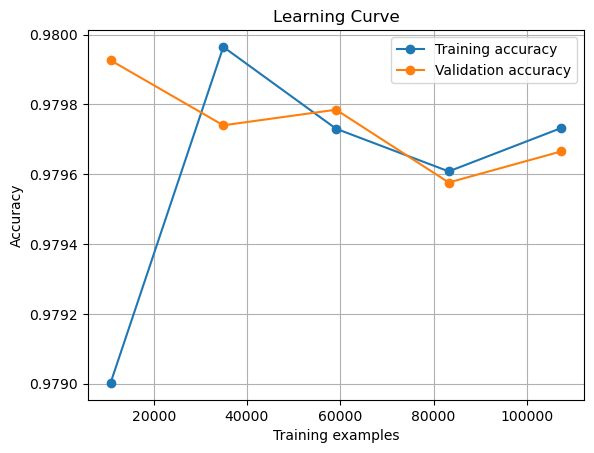

In [17]:
# plot learning curve
train_sizes, train_scores, val_scores = learning_curve(
    svm_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print("Training Accuracy: ", train_scores[-1])

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Model #3: Neural Network

In [18]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras import layers, regularizers

2024-07-19 17:10:23.883867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
])


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
8394/8394 [==============================] - 20s 2ms/step - loss: 0.5269 - accuracy: 0.8841 - val_loss: 0.4715 - val_accuracy: 0.8421
Epoch 2/10
8394/8394 [==============================] - 18s 2ms/step - loss: 0.3054 - accuracy: 0.9457 - val_loss: 0.2657 - val_accuracy: 0.9790
Epoch 3/10
8394/8394 [==============================] - 19s 2ms/step - loss: 0.4117 - accuracy: 0.8349 - val_loss: 0.6911 - val_accuracy: 0.6495
Epoch 4/10
8394/8394 [==============================] - 19s 2ms/step - loss: 0.6595 - accuracy: 0.6481 - val_loss: 0.6497 - val_accuracy: 0.6495
Epoch 5/10
8394/8394 [==============================] - 20s 2ms/step - loss: 0.6492 - accuracy: 0.6481 - val_loss: 0.6478 - val_accuracy: 0.6495
Epoch 6/10
8394/8394 [==============================] - 19s 2ms/step - loss: 0.6486 - accuracy: 0.6481 - val_loss: 0.6478 - val_accuracy: 0.6495
Epoch 7/10
8394/8394 [==============================] - 18s 2ms/step - loss: 0.6486 - accuracy: 0.6481 - val_loss: 0.6479 - val_ac

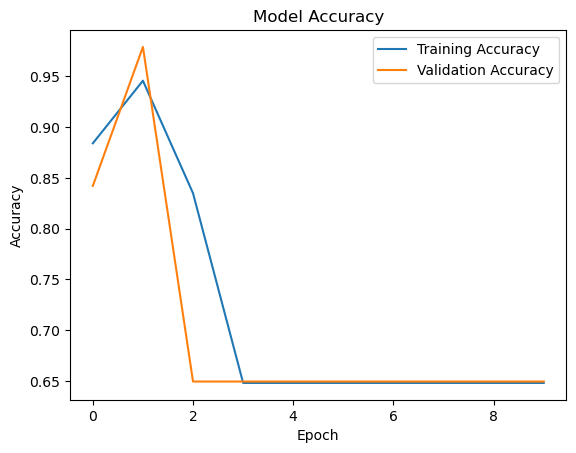

1050/1050 [==============================] - 1s 1ms/step
Precision: 0.649481772694782
Recall: 1.0


In [22]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# calculate precision and recall
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
print("Precision:", precision)
print("Recall:", recall)

In [23]:
print("Training Accuracy: ", history.history['accuracy'][-1])
print("Test Accuracy: ", model.evaluate(X_test, y_test, verbose=0)[1])

Training Accuracy:  0.6481117606163025
Test Accuracy:  0.6494817733764648
